# `dyna-pi`: Dynamic Program Improvement

<img style="width: 40%" src="logo.svg" align="right">

The **dynamic program improvement system** (`dyna-pi`) is an interactive tool for
analyzing and improving dynamic programming algorithms.  We developed this tool
because Finding a correct program with the optimal asymptotic runtime can be
unintuitive, time-consuming, and error-prone.  `dyna-pi` aims to automate this
laborious process.

**Key features**:

1) **Dyna language**: A high-level, domain-specific language for clear and concise dynamic program specification.
2) **Efficient solvers**: General-purpose solvers to execute Dyna programs, including agenda-based fixpoint iteration and semiring Newton's method.
3) **Static analysis**: Type analysis and worst-case time/space complexity analyses.
4) **Program transformations**: Meaning-preserving Dyna-to-Dyna transformations, which systematizes the repeated insights of numerous authors when speeding up algorithms.
5) **Optimizer**: A search algorithm for identifying a sequence of transformations that reduce the runtime complexity given an initial, correct program.
6) **Visualization and debugging**: Tools to aid in the development of correct programs, including integration with Jupyter.

The `dyna-pi` system is based on [Tim Vieira](http://timvieira.github.io)'s 2023
[PhD dissertation](http://timvieira.github.io/doc/2023-timv-dissertation.pdf)
(see also defense [video](https://youtu.be/SUOvgaxFxP4) and
[slides](https://docs.google.com/presentation/d/10LTArMtqI3nc0xnBkq_m7b7Qk312PL4Vb_26q6fA6QU/edit?usp=sharing)).
It is also part of the broader [Dyna project](https://dyna.org/).


**Notice.**  This code release is in its early stages and might have some rough edges.
We welcome feedback and contributions through pull requests, email, and our [issue tracker](http://github.com/timvieira/dyna-pi/issues).

# Demo

In [1]:
import dyna

Helpers

In [2]:
from arsenal import timers, iterview, take

Notebook styling to match the slides:

In [3]:
%%html 
<style>
@import url('https://fonts.googleapis.com/css2?family=Permanent+Marker&display=swap');
h1, h2, h3 { font-family: 'Permanent Marker', cursive; }
</style>

# CKY

In [4]:
cky = dyna.Program("""
phrase(X,I,K) += rewrite(X,W) * word(W,I,K).
phrase(X,I,K) += rewrite(X,Y,Z) * phrase(Y,I,J) * phrase(Z,J,K).
total += phrase(s,0,N) * length(N).

inputs: rewrite(_,_,_); rewrite(_,_); word(_,_,_); length(_).
output: total.
""")

In [5]:
cky

{
  0: phrase(X,I,K) += rewrite(X,W) * word(W,I,K).
  1: phrase(X,I,K) += rewrite(X,Y,Z) * phrase(Y,I,J) * phrase(Z,J,K).
  2: total += phrase(s,0,N) * length(N).
}

Below is example input data corresponding to parsing the input sentence `"Papa ate the caviar with the spoon ."` with a simple grammar.

In [7]:
cky_grammar = dyna.Program("""

% grammar rules
rewrite(s,np,vp) += 1.
rewrite(np,det,n) += 1.
rewrite(np,np,pp) += 1.
rewrite(vp,v,np) += 1.
rewrite(vp,vp,pp) += 1.
rewrite(pp,p,np) += 1.

rewrite(np,"Papa") += 1.
rewrite(v,"ate") += 1.
rewrite(vp,"ate") += 1.
rewrite(det,"the") += 1.
rewrite(n,"caviar") += 1.
rewrite(p,"with") += 1.
rewrite(n,"spoon") += 1.
rewrite(punc,".") += 1.
""")

cky_sentence = dyna.Program("""
% "Papa ate the caviar with the spoon."
length(7) += 1.
word("Papa",0,1) += 1.
word("ate",1,2) += 1.
word("the",2,3) += 1.
word("caviar",3,4) += 1.
word("with",4,5) += 1.
word("the",5,6) += 1.
word("spoon",6,7) += 1.
""")

cky_data = cky_sentence + cky_grammar

The value of `total` will equal the number of parses of the input sentence.  There are two parses of this sentences becase of the prepositional attachment ambiguity.

In [6]:
cky_sol = cky(cky_data).sol()

In [8]:
#cky_sol

In [9]:
cky_sol.user_query('total')

{
  0: total += 2.0.
}

We can also instantiate the program rules against the solution to see them firing.

In [10]:
dyna.util.display_groundings(cky, cky_sol)

,"phrase(X,I,K) += rewrite(X,W) * word(W,I,K)"
1.0,"phrase(np,0,1) += rewrite(np,""Papa"") * word(""Papa"",0,1)"
1.0,"phrase(v,1,2) += rewrite(v,""ate"") * word(""ate"",1,2)"
1.0,"phrase(vp,1,2) += rewrite(vp,""ate"") * word(""ate"",1,2)"
1.0,"phrase(det,2,3) += rewrite(det,""the"") * word(""the"",2,3)"
1.0,"phrase(det,5,6) += rewrite(det,""the"") * word(""the"",5,6)"
1.0,"phrase(n,3,4) += rewrite(n,""caviar"") * word(""caviar"",3,4)"
1.0,"phrase(p,4,5) += rewrite(p,""with"") * word(""with"",4,5)"
1.0,"phrase(n,6,7) += rewrite(n,""spoon"") * word(""spoon"",6,7)"
,"phrase(X,I,K) += rewrite(X,Y,Z) * phrase(Y,I,J) * phrase(Z,J,K)"
1.0,"phrase(s,0,2) += rewrite(s,np,vp) * phrase(np,0,1) * phrase(vp,1,2)"


## Visualization

We can visualize the computation performed in the program as a computation graph.

In [11]:
#dyna.util.open_html\
((cky + cky_data).instantiate(cky_sol).draw())

Hypergraph(nodes=40)

This kind of computation graph is sometimes called a **packed forest** as represents a forest of derivation trees, which we *unpack* below:

In [12]:
#dyna.util.open_html\
((cky + cky_data).derivations(10, 'total').render_graphviz())

Output()

We call these **derivations**.  Some authors call them **proofs**.

The computation graph is essentially a collection or derivations packed together such that common derivations are shared.  The computation graph allows us to represent a larger number of derivations compactly.

## Solvers

Let's see how CKY works on our example data from earlier

In [13]:
p = cky + cky_data   # add the input data to the program rules

**Forward chaining** is an iterative algorithm.  In each iteration, it applies the rules of the program to a **chart** (solution estimate) to derive the next chart.  Once the chart is unchanged, the algorithm halts.

We initialize to the empty chart (i.e., all items have value zero).

In [14]:
chart = dyna.Program(inputs='')

By repeatedly evaluating the cell below, we will see what the forward chaining steps do.

In [23]:
new_chart = p.step(chart)
dyna.util.display_chart_and_groundings(cky, chart, new_chart)
chart = new_chart

In the thesis, we describe a more efficient *prioritized* forward chaining strategy that exploits sparsity in the computation graph.

## Solving Cyclical Programs

**What about cyclical programs?**

In [24]:
p = dyna.Program("""
x += a * x.
x += 1.
a += 0.5.

outputs: x.
""")

In [25]:
p.draw()

Hypergraph(nodes=2)

In [26]:
p.fc(5).user_query('x')

{
  0: x += 1.9375.
}

In [27]:
p.fc(10).user_query('x')

{
  0: x += 1.998046875.
}

In [28]:
p.fc(100).user_query('x')

{
  0: x += 2.0.
}

Convergence rate depends on the value of $\texttt{a}$:  

- If $|\texttt{a}|$ is small, numerical convergence is fast

- If $|\texttt{a}| \ge 1$ forward chaining will diverge.

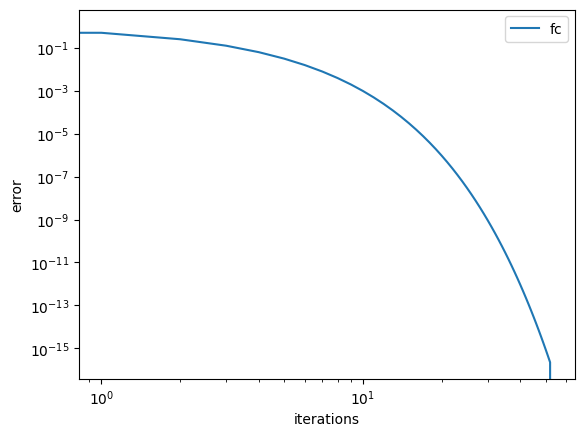

In [29]:
want = 2
err_fc = [abs(want - chart.rules[0].body[0]) for chart in take(100, p._fc()) if chart]
pl.loglog(err_fc, label='fc')
pl.ylabel('error'); pl.xlabel('iterations'); pl.legend(loc='best');

**A harder cyclical program.** Numerical convergence of forward chaining can be slow.  The following program shows a case where fixpoint iteration is slow to converge and Netwon's algorithm is much faster.

In [30]:
p = dyna.Program("""

x += 0.5 * x * x.
x += 0.5.

outputs: x.

""")

The solution to this program is `x = 1` (hint: use quadratic formula to solve $x = \frac{1}{2} x^2 + \frac{1}{2}$).

On this program, forward chaining converges *very* slowly.

In [31]:
p.fc(100)

{
  0: x += 0.9812084402587709.
}

In [32]:
p.fc(1_000)

{
  0: x += 0.9980172182771205.
}

For difficult cyclical programs, we use a generalized Newton's algorithm to solve for the values.

In [33]:
p.newton(10)

{
  0: x += 0.9990234375.
}

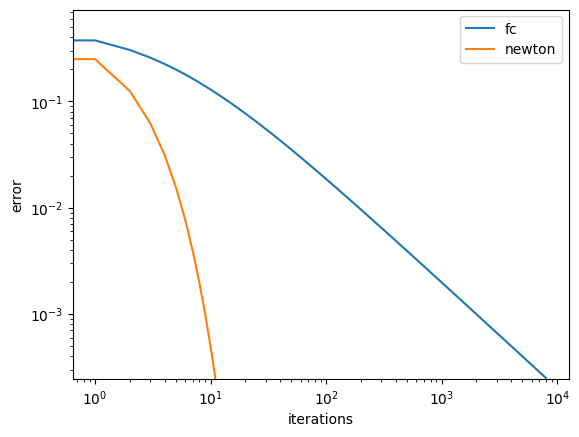

In [34]:
want = 1
err_fc = [abs(want - chart.rules[0].body[0]) for chart in take(8_000, p._fc()) if chart]
err_newton = [abs(want - chart.rules[0].body[0]) for (_, _, _, _, chart) in take(12, p._newton())]
pl.loglog(err_fc, label='fc')
pl.loglog(err_newton, label='newton')
pl.ylabel('error'); pl.xlabel('iterations'); pl.ylim(min(min(err_fc), min(err_newton)), None)
pl.legend(loc='best');

# Transformations

## Basic Unfold  and Fold

The example below illustrates fold and unfold.  The example uses the regular-expression semiring.

**Unfold**: Below, we unfold the `q` subgoal of the first rule.  This replaces the subgoal with the bodies of the two rules that define it.

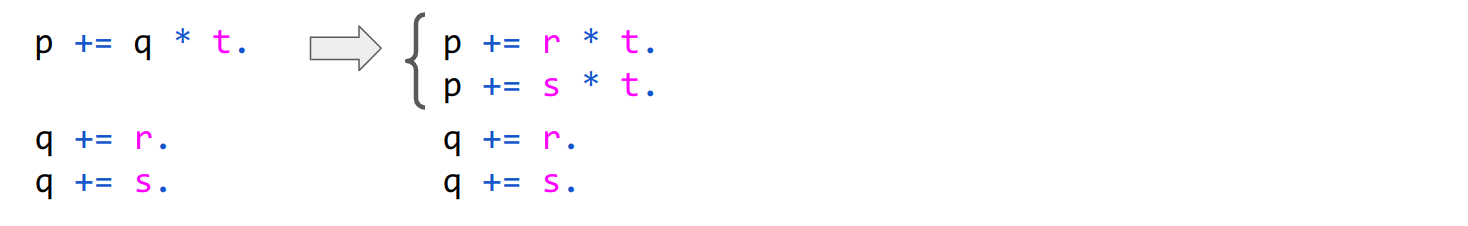

In [ ]:
pqrst = dyna.Program("""
p += q * `t`.
q += `r`.
q += `s`.
""", semiring=dyna.Symbol)

In [ ]:
pqrst.unfold(0,0).sort()

**Fold** is the mirror image of unfold.

In [ ]:
dyna.Program("""
p += `r` * `t`.
p += `s` * `t`.
q += `r`.
q += `s`.
""").megafolds()[0]

**Strongly equivalent:** a value-preserving bijections between the derivation sets

In [ ]:
pqrst.derivations(10,'X')

In [ ]:
table = []
for x in pqrst.derivations(10,'X'):
    y = pqrst.Transform(x, pqrst.unfold(0,0))   # apply the bijective mapping
    table.append([x, y])

In [ ]:
dyna.util.display_table(table)

### Length-4 paths

In [ ]:
path4 = dyna.Program("""
total += w(Y₁,Y₂) * w(Y₂,Y₃) * w(Y₃,Y₄) * w(Y₄,Y₅).

inputs: w(_,_).
output: total.
""")

In [ ]:
path4_input_type = """
w(I,J) += n(I) * n(J). 
inputs: n(_).
"""

In [ ]:
path4_opt = path4.beam(50,5,verbosity=0).best.sort()
display(path4_opt)
display(path4_opt.type_analysis(path4_input_type).runtime().x.expand())

## CKY Improvement

In [ ]:
cky

In [ ]:
cky_optimized = cky.define('tmp(X,I,J,Z) += rewrite(X,Y,Z) * phrase(Y,I,J).').megafolds()[0]

In [ ]:
cky_optimized

In [ ]:
cky_input_type = """

params:
    k(X);   % grammar symbols
    w(W);   % sentence symbols
    n(I).   % sentence positions

word(W,I,K) += w(W) * n(I) * n(K).
length(N) += n(N).
rewrite(X,Y,Z) += k(X) * k(Y) * k(Z).
rewrite(X,W) += k(X) * w(W).

"""
cky_optimized.type_analysis(cky_input_type).runtime(fast_mode=1).x.expand()

In [ ]:
cky.type_analysis(cky_input_type).runtime(fast_mode=1).x.expand()

Since the number of nonterminals over each span is small in this program the savings due to the "hook trick" are small.

In [ ]:
D = cky_data

T = timers()
for _ in iterview(range(25)):
    with T['cky-optimized']:
        cky_optimized(D)    
    with T['cky-basic']:
        cky(D)
T.compare()

In [ ]:
synthetic_data = dyna.Program("""
word(W,I,K) += w(W) * n(I) * n(K) * (K is I + 1).
length(N) += n(N).
rewrite(X,Y,Z) += k(X) * k(Y) * k(Z).
rewrite(X,W) += k(X) * w(W).

w("a").
k(a). k(b). k(c). k(d). k(e). k(f). k(s).
n(0). n(1). n(2). n(3). n(4). n(5).
""").sol()
#cky(synthetic_data).user_query('total')

D = synthetic_data

T = timers()
for _ in iterview(range(5)):
    with T['cky-optimized']:
        cky_optimized(D)    
    with T['cky-basic']:
        cky(D)
T.compare()

## CKY - Unfold Grammar

We can use unfold to specialize the program to the specific grammar

In [35]:
cky + cky_grammar

{
  0: phrase(X,I,K) += rewrite(X,W) * word(W,I,K).
  1: phrase(X,I,K) += rewrite(X,Y,Z) * phrase(Y,I,J) * phrase(Z,J,K).
  2: total += phrase(s,0,N) * length(N).
  3: rewrite(s,np,vp) += 1.
  4: rewrite(np,det,n) += 1.
  5: rewrite(np,np,pp) += 1.
  6: rewrite(vp,v,np) += 1.
  7: rewrite(vp,vp,pp) += 1.
  8: rewrite(pp,p,np) += 1.
  9: rewrite(np,"Papa") += 1.
  10: rewrite(v,"ate") += 1.
  11: rewrite(vp,"ate") += 1.
  12: rewrite(det,"the") += 1.
  13: rewrite(n,"caviar") += 1.
  14: rewrite(p,"with") += 1.
  15: rewrite(n,"spoon") += 1.
  16: rewrite(punc,".") += 1.
}

In [36]:
cky_specialized = (cky + cky_grammar).set_input_types('word(_,_,_). length(_).').unfold(1,0).unfold(0,0).constant_folding().prune()
cky_specialized

{
  0: total += phrase(s,0,N) * length(N).
  1: phrase(s,0,K) += phrase(np,0,J) * phrase(vp,J,K).
  2: phrase(np,I,K) += phrase(det,I,J) * phrase(n,J,K).
  3: phrase(np,I,K) += phrase(np,I,J) * phrase(pp,J,K).
  4: phrase(vp,I,K) += phrase(v,I,J) * phrase(np,J,K).
  5: phrase(vp,I,K) += phrase(vp,I,J) * phrase(pp,J,K).
  6: phrase(pp,I,K) += phrase(p,I,J) * phrase(np,J,K).
  7: phrase(np,I,K) += word("Papa",I,K).
  8: phrase(v,I,K) += word("ate",I,K).
  9: phrase(vp,I,K) += word("ate",I,K).
  10: phrase(det,I,K) += word("the",I,K).
  11: phrase(n,I,K) += word("caviar",I,K).
  12: phrase(p,I,K) += word("with",I,K).
  13: phrase(n,I,K) += word("spoon",I,K).
}

In [37]:
T = timers()
for _ in iterview(range(25)):
    with T['cky-specialized']:
        cky_specialized(cky_sentence)
    with T['cky-basic']:
        cky(cky_data)
T.compare()

Output()

cky-specialized is 1.2912x faster than cky-basic (p=0.03444, mean: cky-basic: 0.0133188, cky-specialized: 0.0103148)


## Generalized Unfold and Fold Transformation

### Unfolding the Geometric Series

In [ ]:
geom = dyna.Program("""
x += `b`.
x += `a` * x.

output: x.
""", semiring=dyna.Symbol)

In [ ]:
geom

Unfolding *once* does what we expect:

In [ ]:
geom.unfold(1,1)

However, unfolding *twice* does something a little weird:

In [ ]:
geom.unfold(1,1).unfold(2,2)

The recurrence has be unrolled to four levels rather than 3.

With **generalized unfold**, we can specify which program to use as **auxiliary definitions**:

In [ ]:
geom.unfold(1,1).unfold(2,2,defs=geom)

And, similarly, **generalized fold** will fold with respect to auxiliary definitions.

### Total weight of all paths from `start` to `stop`

In [ ]:
paths = dyna.Program("""

goal += start(I) * path(I,K) * stop(K).

path(I,K) += path(I,J) * edge(J,K).
path(I,I).

inputs: start(_); edge(_,_); stop(_).
outputs: goal.

""")

In [ ]:
paths1 = paths.define('startpath(K) += start(I) * path(I,K).')
paths1

In [ ]:
paths2 = paths1.megafolds(paths1)[0]
paths2

In [ ]:
paths3 = paths2.unfold(3,1)
paths3

In [ ]:
paths4 = paths3.megafolds(paths1)[1]
paths4.sort()

In [ ]:
paths4.prune().sort()

### Explicit Paths

The program below is a rather direct way to write the sum over all paths in a graph ending in a set `stop`.

In [38]:
explicit_path = dyna.Program("""

path([X]) += stop(X).
path([X1,X2|Xs]) += edge(X1,X2) * path([X2|Xs]).
goal += start(X) * path([X|Xs]).

inputs: start(_); edge(_,_); stop(_).
outputs: goal.
""")

In [39]:
path_data = dyna.Program("""
start(a) += 1.
edge(a,b) += 0.5.
edge(b,c) += 0.5.
edge(c,a) += 0.5.
stop(a) += 1.
""")

In [40]:
(explicit_path + path_data).fc(20)

{
  0: path([a]) += 1.0.
  1: path([a,b,c,a]) += 0.125.
  2: path([a,b,c,a,b,c,a]) += 0.015625.
  3: path([a,b,c,a,b,c,a,b,c,a]) += 0.001953125.
  4: path([a,b,c,a,b,c,a,b,c,a,b,c,a]) += 0.000244140625.
  5: path([a,b,c,a,b,c,a,b,c,a,b,c,a,b,c,a]) += 3.0517578125e-05.
  6: path([a,b,c,a,b,c,a,b,c,a,b,c,a,b,c,a,b,c,a]) += 3.814697265625e-06.
  7: path([b,c,a]) += 0.25.
  8: path([b,c,a,b,c,a]) += 0.03125.
  9: path([b,c,a,b,c,a,b,c,a]) += 0.00390625.
  10: path([b,c,a,b,c,a,b,c,a,b,c,a]) += 0.00048828125.
  11: path([b,c,a,b,c,a,b,c,a,b,c,a,b,c,a]) += 6.103515625e-05.
  12: path([b,c,a,b,c,a,b,c,a,b,c,a,b,c,a,b,c,a]) += 7.62939453125e-06.
  13: path([c,a]) += 0.5.
  14: path([c,a,b,c,a]) += 0.0625.
  15: path([c,a,b,c,a,b,c,a]) += 0.0078125.
  16: path([c,a,b,c,a,b,c,a,b,c,a]) += 0.0009765625.
  17: path([c,a,b,c,a,b,c,a,b,c,a,b,c,a]) += 0.0001220703125.
  18: path([c,a,b,c,a,b,c,a,b,c,a,b,c,a,b,c,a]) += 1.52587890625e-05.
  19: goal += 1.142852783203125.
  20: start(a) += 1.0.
  21: edge(a,b) += 0.5.
  22: edge(b,c) += 0.5.
  23: edge(c,a) += 0.5.
  24: stop(a) += 1.0.
}

In [41]:
opt = explicit_path.optimizer().run(500)
best = opt.optimize_plans().prune()
best

{
  0: goal += $gen1(X) * start(X).
  1: $gen1(X) += $gen1(X2) * edge(X,X2).
  2: $gen1(X) += stop(X).
}

In [42]:
path_input_type = """
start(I) += n(I).
edge(I,K) += n(I) * n(K).
stop(K) += n(K).
inputs: n(N).
"""

In [43]:
runtime = best.type_analysis(path_input_type).runtime().x.expand()
runtime

n**2 + 4*n + 6

In [44]:
explicit_path.type_analysis(path_input_type).runtime().x.expand()

oo

# More

## CKY - Program Analysis

Simple input-type specification:

In [ ]:
cky_input_type = """

params:
    k(X);   % grammar symbols
    w(W);   % sentence symbols
    n(I).   % sentence positions

word(W,I,K) += w(W) * n(I) * n(K) * (I < K).
length(N) += n(N).
rewrite(X,Y,Z) += k(X) * k(Y) * k(Z).
rewrite(X,W) += k(X) * w(W).

"""
cky_t = cky.type_analysis(cky_input_type, """
(I < K) :- (I < J), (J < K).
$fail :- (I < I).
""")
cky_t

Space complexity

In [ ]:
cky_t.size().x

Runtime complexity

In [ ]:
cky_t.runtime(fast_mode=1).x.expand()

## Semirings

**Boolean**

In [8]:
(cky + cky_data).lift_semiring(dyna.Boolean).user_query('total')

{
  0: total += True.
}

**Top K**

In [9]:
for x in (cky + cky_data).lift_semiring(dyna.LazySort).user_query('total').rules[0].body[0]:
    print()
    print(x.score, x.flat_data_list())


1 [rewrite(s,np,vp), rewrite(np,"Papa"), word("Papa",0,1), rewrite(vp,v,np), rewrite(v,"ate"), word("ate",1,2), rewrite(np,np,pp), rewrite(np,det,n), rewrite(det,"the"), word("the",2,3), rewrite(n,"caviar"), word("caviar",3,4), rewrite(pp,p,np), rewrite(p,"with"), word("with",4,5), rewrite(np,det,n), rewrite(det,"the"), word("the",5,6), rewrite(n,"spoon"), word("spoon",6,7), length(7)]

1 [rewrite(s,np,vp), rewrite(np,"Papa"), word("Papa",0,1), rewrite(vp,vp,pp), rewrite(vp,v,np), rewrite(v,"ate"), word("ate",1,2), rewrite(np,det,n), rewrite(det,"the"), word("the",2,3), rewrite(n,"caviar"), word("caviar",3,4), rewrite(pp,p,np), rewrite(p,"with"), word("with",4,5), rewrite(np,det,n), rewrite(det,"the"), word("the",5,6), rewrite(n,"spoon"), word("spoon",6,7), length(7)]


**Min-plus**

In [10]:
(cky + cky_data).lift_semiring(dyna.MinPlus).user_query('total')

{
  0: total += MinPlus(21, (((rewrite(s,np,vp), (rewrite(np,"Papa"), word("Papa",0,1))), ((rewrite(vp,vp,pp), ((rewrite(vp,v,np), (rewrite(v,"ate"), word("ate",1,2))), ((rewrite(np,det,n), (rewrite(det,"the"), word("the",2,3))), (rewrite(n,"caviar"), word("caviar",3,4))))), ((rewrite(pp,p,np), (rewrite(p,"with"), word("with",4,5))), ((rewrite(np,det,n), (rewrite(det,"the"), word("the",5,6))), (rewrite(n,"spoon"), word("spoon",6,7)))))), length(7))).
}

**Regular expressions**

In [11]:
class NewSymbol(dyna.Symbol):
    @classmethod
    def lift(cls, x, y):
        return dyna.Symbol(y.args[0]) if y.fn == 'word' else dyna.Symbol.one

In [12]:
(cky + cky_data).lift_semiring(NewSymbol).user_query('total')

{
  0: total += Papa⋅ate⋅the⋅caviar⋅with⋅the⋅spoon.
}

The example below that the value of `x` is equal to a regular language ${\tt\color{magenta}a}^* {\tt\color{magenta}b}$ accepted by a finite-state automaton

In [13]:
geom = dyna.Program("""
x += `b`.
x += `a` * x.
""", semiring=dyna.Symbol)
geom_sol = geom.newton()
geom_sol

{
  0: x += (a + a⋅(a)*⋅a + ε)⋅b.
}

In [14]:
geom_sol.rules[0].body[0].fsa.min()

b + a⋅(a)*⋅b

## Total Weight of all Paths

In [ ]:
p = dyna.Program("""

goal += start(I) * path(I,K) * stop(K).

path(I,K) += edge(I,J) * path(J,K).
path(I,I).

inputs: start(_); edge(_,_); stop(_).
outputs: goal.

""")

In [ ]:
p

This program defines `path` to be the total weight of all paths of length $\ge 0$.  This is also known as the reflexive and transitive closure of the `edge` relation.  We can derive the transitive closure (with out reflexivity) using the following transformation.  Notice that we did not change the meaning of `goal` (it still sums the length $=0$ paths), but the `path` relation has changed its meaning.

In [ ]:
p.elim(2)

In [ ]:
D = """
edge("Boston", "New York") += 2.
edge("Boston", "Chicago") += 12.
edge("Boston", "Miami") += 15.
edge("Denver", "Chicago") += 8.
edge("Denver", "Seattle") += 10.
edge("Denver", "Dallas") += 12.
edge("Chicago", "Denver") += 7.
edge("Chicago", "Boston") += 12.
edge("Chicago", "Seattle") += 10.
edge("Seattle", "Denver") += 8.
edge("Seattle", "San Francisco") += 9.
edge("Seattle", "Chicago") += 10.
edge("San Francisco", "Seattle") += 2.
edge("San Francisco", "Los Angeles") += 4.
edge("San Francisco", "Denver") += 12.
edge("Los Angeles", "San Francisco") += 2.
edge("Los Angeles", "Dallas") += 13.
edge("Los Angeles", "Miami") += 2.
edge("Miami", "Dallas") += 6.
edge("Miami", "New York") += 9.
edge("Miami", "Boston") += 15.
edge("Dallas", "Los Angeles") += 14.
edge("Dallas", "Denver") += 12.
edge("Dallas", "Miami") += 9.
edge("New York", "Boston") += 2.
edge("New York", "Miami") += 13.
edge("New York", "Chicago") += 8.
"""

#display(dyna.graphs.WeightedGraph.from_program(D))

In [ ]:
p.lift_semiring(dyna.MinPlus)(D, solver=2).sol().user_lookup('path("New York", J)')

In [ ]:
D = dyna.Program("""
start(a) += 1.
edge(a,b) += 0.5.
edge(b,c) += 0.5.
edge(c,a) += 0.5.
stop(a) += 1.
""")

D = dyna.Program("""
start(a) += 1.
edge(a,b) += 1.
edge(b,d) += 1.
edge(a,c) += 1.
edge(c,d) += 1.
edge(b,c) += 1.
stop(d) += 1.
""")

In [ ]:
sol = (p + D).fc(10)
sol

In [ ]:
# example is a little trickier because of the nonground item
#(p + D).instantiate(sol).prune().draw()   

In [ ]:
#(p + D).derivations(5, 'goal')

## Semi-Automated Search

The `dyna-pi` toolkit supports semi-automated search.

In [16]:
p = dyna.Program("""

path([X1,X2|Xs]) += edge(X1,X2) * path([X2|Xs]).
path([X]) += stop(X).
goal += start(X) * path([X|Xs]).

inputs: start(_); edge(_,_); stop(_).
outputs: goal.
""")

In the example below, we string together a sequences of search operations that resemble the "tactics" used in proof assistants (e.g., [lean](https://lean-lang.org/)).

In [21]:
m = dyna.make_smt_measure(p)   # measure-based safety conditions for fold/unfold transformations

C = (p.to_collection()
 .eurekas()
 .unfolds_first()
 .dedup()
 .folds_seq()
 .filter(m.safe)
 .prune_fast()
 .dedup()
)

print(f'{len(C)} nodes')
C.sort(dyna.Program.degrees)[0]

15 nodes


{
  0: $gen8(X) += $gen8(X2) * edge(X,X2).
  1: goal += $gen8(X) * start(X).
  2: $gen8(X) += stop(X).
}

In [18]:
C.graph

<ProgramGraph 17 nodes, 17 hyperedges>

In [ ]:
#from IPython.display import FileLink, FileLinks
#filename = '/tmp/tmp.html'
#with open(filename, 'w', encoding='utf-8') as f: f.write(C.graph._repr_html_())
#FileLink(filename)

The fully automated search explores much more of the graph ($\approx 200$ programs).

In [ ]:
optimizer = p.optimizer(p_greedy=0.5, seed=0)
optimizer.run(200).optimize_plans().prune()

## Type-based Program Specialization

In [ ]:
q = dyna.Program("""
goal += a(I,I).
a(I,K) += b(I,J) * c(J,K).
goal += dead(X).

input: b(_,_); c(_,_).
output: goal.
""")

In [ ]:
q.type_analysis()

In [ ]:
q.usefulness_analysis()

In [ ]:
q.abbreviate(types=q.usefulness_analysis()).prune().sort()

Bounds

In [ ]:
import dyna.analyze.runtime
#n = dyna.analyze.runtime._syms['n']   # symbol name to make it orange
#n.name = colors.orange % 'n'

In [ ]:
q.type_analysis("""
b(I,J) :- n(I), n(J).
c(I,J) :- n(I), n(J).
inputs: n(_).
""").show_runtime()

In [ ]:
q.prune(specialize=True).type_analysis("""
b(I,J) :- n(I), n(J).
c(I,J) :- n(I), n(J).
inputs: n(_).
""").show_runtime()

In [ ]:
S = q.type_analysis("""
b(I,J) :- n(I), n(J).
c(I,J) :- n(I), n(J).
inputs: n(_).
""")

In [ ]:
S.show_size(full=True)

print(colors.light.magenta % '\noverall', S.size())

## Weighted Peano Numbers

This example shows how the left-corner transformation can be used to speed-up the following sum over weighted peano numbers.

In [ ]:
peano = dyna.Program("""
peano(z) += 1.
peano(s(N)) += a * peano(N).
a += .5.

goal += peano(N).

outputs: goal.

""")

In [ ]:
sol = peano.fc(30)
sol

In [ ]:
sol.user_lookup('goal')    # approximation to goal is pretty accurate if |a| is small, if |a| >= 1 it diverges.

The following mysterious transformation makes the computation of `goal` program run efficiently:

In [ ]:
peano

In [ ]:
peano_fast = peano.lct({3:0, 1:1}).elim(0).elim(0).prune_fast()
peano_fast

Now, the program runs efficiently as the new items `(goal / peano($X0)` have `$X0` uninstantiated.

In [ ]:
peano_fast.prune(specialize=0).sol()